In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
from os.path import join
import torch
import torch as th
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm.auto import trange
from contextlib import redirect_stdout
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.cv2_eval_utils import evaluate_pipeline_on_prompts, print_evaluation_summary
from utils.relation_shape_dataset_lib import ShapesDataset
from utils.variance_partition_with_effects import variance_partition_with_effects#, variance_partition
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom, PixArtAlphaPipeline_custom_CLIP
from utils.pixart_utils import state_dict_convert
from utils.pixart_utils import construct_diffuser_pipeline_from_config, PixArt_model_configs
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

In [3]:
from itertools import product
def generate_all_prompt_collection(spatial_phrases, 
                               prompt_template="{color1} {shape1} is {rel_text} {color2} {shape2}",):
    color_list = ['red', 'blue']
    shape_list = ['square', 'triangle', 'circle']
    prompt_collection = []
    scene_info_collection = []
    for color1, color2 in product(color_list, color_list):
        if color1 == color2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(shape_list, shape_list):
            if shape1 == shape2:
                continue
            for spatial_relationship, rel_text_collection in spatial_phrases.items():
                if spatial_relationship in ["in_front", "behind"]:
                    continue
                for rel_text in rel_text_collection:
                    prompt = prompt_template.format(color1=color1, shape1=shape1, rel_text=rel_text, color2=color2, shape2=shape2)
                    scene_info = {
                        "color1": color1,
                        "shape1": shape1,
                        "color2": color2,
                        "shape2": shape2,
                        "spatial_relationship": spatial_relationship
                    }
                    prompt_collection.append(prompt)
                    scene_info_collection.append(scene_info)
    return prompt_collection, scene_info_collection

In [4]:
from experimental_scripts.generalization_profile_eval_cli import evaluate_pipeline_on_prompts_with_cached_embeddings, precompute_embeddings
def find_shape_index(tokens, shape):
    """Find the token index for a shape in the tokenized text."""
    shape_mask_idx = None
    
    # Look for exact token matches first
    for i, token in enumerate(tokens):
        token_clean = token.strip().lower()
        shape_clean = shape.strip().lower()
        
        # Check for exact matches first
        if token_clean == shape_clean or token_clean == f"▁{shape_clean}":
            shape_mask_idx = i
            break
    
    # If exact match not found, look for partial matches
    if shape_mask_idx is None:
        for i, token in enumerate(tokens):
            token_clean = token.strip().lower()
            shape_clean = shape.strip().lower()
            
            if shape_clean in token_clean:
                shape_mask_idx = i
                break
    
    return shape_mask_idx

def find_word_index(tokens, word):
    """Find the token index for a shape in the tokenized text."""
    shape_mask_idx = None
    
    # Look for exact token matches first
    for i, token in enumerate(tokens):
        token_clean = token.strip().lower()
        shape_clean = word.strip().lower()
        
        # Check for exact matches first
        if token_clean == shape_clean or token_clean == f"▁{shape_clean}":
            shape_mask_idx = i
            break
    
    # If exact match not found, look for partial matches
    if shape_mask_idx is None:
        for i, token in enumerate(tokens):
            token_clean = token.strip().lower()
            shape_clean = word.strip().lower()
            
            if shape_clean in token_clean:
                shape_mask_idx = i
                break
    
    return shape_mask_idx

### Loading in models

In [5]:
model_run_name = "objrel_T5_DiT_B_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
# model_run_name = "objrel_T5_DiT_mini_pilot_WDecay" # "objrel_rndembdposemb_DiT_B_pilot" 
# ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
ckpt_name = "epoch_4000_step_160000.pth"  # "epoch_4000_step_160000.pth" 
text_encoder_type = "T5" 
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
config = read_config(join(savedir, 'config.py'))
# Build pipeline from config
pipeline = construct_diffuser_pipeline_from_config(config, pipeline_class=PixArtAlphaPipeline_custom)
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/training_datasets/random_emd_dictionary'
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
if text_encoder_type == "T5":
    text_encoder = T5EncoderModel.from_pretrained(T5_path, load_in_8bit=False, torch_dtype=torch.bfloat16, )
    
ckptdir = join(savedir, "checkpoints")

ckpt = torch.load(join(ckptdir, ckpt_name))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))
# pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict']))
pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=torch.float16);
pipeline.text_encoder = text_encoder.to(device="cuda", )

weight_dtype: torch.float16


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_3236954/1359738890.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, ckpt_name))


### Make all embeddings

In [6]:
dataset_tmp = ShapesDataset(num_images=10000)
prompt_collection_all, scene_info_collection_all = generate_all_prompt_collection(dataset_tmp.spatial_phrases,
                                prompt_template="{color1} {shape1} is {rel_text} {color2} {shape2}",)
embedding_allrel_allobj = precompute_embeddings({"base":(prompt_collection_all, scene_info_collection_all)}, 
                                        pipeline.tokenizer, pipeline.text_encoder, 
                                        max_sequence_length=20, device="cuda")
prompt_scene_info_all_df = pd.DataFrame(scene_info_collection_all)
prompt_scene_info_all_df["prompt"] = prompt_collection_all
prompt_scene_info_all_df
wordvec_obj1_col = []
wordvec_obj2_col = []
for row in prompt_scene_info_all_df.itertuples():
    tokenized = pipeline.tokenizer(row.prompt, max_length=20, padding="max_length", truncation=True, return_tensors="pt")
    token_ids = tokenized['input_ids'][0]
    tokens = [pipeline.tokenizer.decode([token_id]) for token_id in token_ids]
    
    shape1_mask_idx = find_shape_index(tokens, row.shape1)
    shape2_mask_idx = find_shape_index(tokens, row.shape2)
    cap_embeds = embedding_allrel_allobj[f"base::{row.prompt}"]['caption_embeds']
    if shape1_mask_idx is None or shape2_mask_idx is None:
        print(f"Prompt: {row.prompt}")
        print(f"Shape1 ({row.shape1}) at index: {shape1_mask_idx}")
        print(f"Shape2 ({row.shape2}) at index: {shape2_mask_idx}")
        print("---")
        raise ValueError("Shape index not found")
    wordvec_obj1_col.append(cap_embeds[0, shape1_mask_idx, :])
    wordvec_obj2_col.append(cap_embeds[0, shape2_mask_idx, :])
wordvec_obj1_mat = torch.stack(wordvec_obj1_col, dim=0)
wordvec_obj2_mat = torch.stack(wordvec_obj2_col, dim=0)
with torch.no_grad():
    wordvec_obj1_mat_proj = pipeline.transformer.caption_projection(wordvec_obj1_mat.half().cuda())
    wordvec_obj2_mat_proj = pipeline.transformer.caption_projection(wordvec_obj2_mat.half().cuda())

Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)


In [7]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]

var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
             "color1": prompt_scene_info_all_df["color1"],
             "shape1": prompt_scene_info_all_df["shape1"],
             "color2": prompt_scene_info_all_df["color2"],
             "shape2": prompt_scene_info_all_df["shape2"],
             "color1shape1": prompt_scene_info_all_df["color1shape1"],
             "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.753546
Total R² (all features): 0.7535


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,spatial_relationship,8,7,247,4290.389616,516.818384,0.120460,5.168184e+02,1.204595e-01,3.283047e-01,0.009901
1,color2shape2,6,5,247,4290.389616,2479.528869,0.577926,5.412790e+01,1.261608e-02,4.869750e-02,0.009901
2,color1shape1,6,5,247,4290.389616,1051.811239,0.245155,2.134845e+01,4.975877e-03,1.979030e-02,0.524752
3,color2,2,1,247,4290.389616,200.893890,0.046824,1.588616e-13,3.702731e-17,1.502401e-16,1.000000
4,color1,2,1,247,4290.389616,200.893890,0.046824,1.588616e-13,3.702731e-17,1.502401e-16,1.000000
5,shape1,3,2,247,4290.389616,810.487524,0.188908,-1.650572e-12,-3.847138e-16,-1.560994e-15,1.000000
6,shape2,3,2,247,4290.389616,2205.425711,0.514039,-2.652649e-12,-6.182769e-16,-2.508688e-15,1.000000


In [10]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]

var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj1_mat.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],
             "shape1": prompt_scene_info_all_df["shape1"],
             "color2": prompt_scene_info_all_df["color2"],
             "shape2": prompt_scene_info_all_df["shape2"],
             "color1shape1": prompt_scene_info_all_df["color1shape1"],
            #  "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.756847
Total R² (all features): 0.7568


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,spatial_relationship,8,7,249,3455.655985,275.003875,0.079581,2.750039e+02,7.958080e-02,2.465834e-01,0.009901
1,shape2,3,2,249,3455.655985,703.051744,0.203450,1.898422e+02,5.493665e-02,1.842957e-01,0.009901
2,color1shape1,6,5,249,3455.655985,2150.556591,0.622329,6.450835e+01,1.866747e-02,7.129872e-02,0.009901
3,shape1,3,2,249,3455.655985,1859.410550,0.538077,-4.704071e-12,-1.361267e-15,-5.598396e-15,1.000000
4,color2,2,1,249,3455.655985,226.637687,0.065585,-5.099588e-12,-1.475722e-15,-6.069107e-15,1.000000


In [8]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]

var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],
             "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
            #  "shape2": prompt_scene_info_all_df["shape2"],
            #  "color1shape1": prompt_scene_info_all_df["color1shape1"],
             "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

Total R2 (all features): 0.748570
Total R² (all features): 0.7486


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color2shape2,6,5,249,4290.389616,2479.528869,0.577926,1884.350321,0.439203,0.635942,0.009901
1,spatial_relationship,8,7,249,4290.389616,516.818384,0.120460,516.818384,0.120460,0.323912,0.009901
2,shape1,3,2,249,4290.389616,810.487524,0.188908,215.308976,0.050184,0.166385,0.009901


In [12]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]
print("shape2, T5 embedding, caption projection")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(wordvec_obj2_mat_proj.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],
             "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
            #  "shape2": prompt_scene_info_all_df["shape2"],
            #  "color1shape1": prompt_scene_info_all_df["color1shape1"],
             "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

shape2, T5 embedding, caption projection
Total R2 (all features): 0.555583
Total R² (all features): 0.5556


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color2shape2,6,5,249,5780.676321,1565.549522,0.270825,1452.318637,0.251237,0.361152,0.009901
1,spatial_relationship,8,7,249,5780.676321,1230.125993,0.212800,1230.125993,0.212800,0.323789,0.009901
2,shape1,3,2,249,5780.676321,529.198075,0.091546,415.967191,0.071958,0.139352,0.009901


### Filtering the heads

In [13]:
import numpy as np
import matplotlib.pyplot as plt
def ramp_alignment_metrics(M, dvec, eps=1e-12):
    """
    Returns:
      cosine     : [-1, 1] alignment with spatial direction (scale-free)
      projection : signed magnitude of alignment (units of M)
    """
    H, W = M.shape
    d = np.array(dvec)
    d = d / np.linalg.norm(d)
    
    # coordinate grid
    xs = np.linspace(-1, 1, W)
    ys = np.linspace(-1, 1, H)
    X, Y = np.meshgrid(xs, ys)

    # ramp template
    T = d[0] * X + d[1] * Y
    T = T - T.mean()                      # remove DC (important!)
    T_norm = np.linalg.norm(T) + eps
    T_unit = T / T_norm                   # unit template

    # centered map
    # A = M.astype(float)
    A = M - M.mean()
    A_norm = np.linalg.norm(A) + eps

    # (1) signed projection magnitude
    projection = np.sum(A * T / T_norm)

    # (2) cosine / correlation
    cosine = projection / A_norm

    return dict(
        cosine=cosine,
        projection=projection,
        energy=A_norm,
        template_norm=T_norm,
    )


def visualize_direction_vectors(H=8, W=8):
    direction_vector = {
        'above': [0, -1],
        'below': [0, 1],
        'left': [-1, 0],
        'lower_left': [-1, 1],
        'lower_right': [1, 1],
        'right': [1, 0],
        'upper_left': [-1, -1],
        'upper_right': [1, -1]
    }

    # Visualize the template ramps in 2x4 subplots
    H, W = 8, 8  # set the dimensions of the grid (adjust if appropriate)
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for idx, (name, dvec) in enumerate(direction_vector.items()):
        xs = np.linspace(-1, 1, W)
        ys = np.linspace(-1, 1, H)
        X, Y = np.meshgrid(xs, ys)
        d = np.array(dvec)
        d = d / np.linalg.norm(d)
        T = d[0] * X + d[1] * Y
        T = T - T.mean()
        
        ax = axes[idx // 4, idx % 4]
        im = ax.imshow(T, cmap='coolwarm')
        ax.set_title(name)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


# visualize_direction_vectors()
# inner_prod_mat[:, i_word:i_word+1].view(8, 8)
# plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
# plt.title(f"{levels_map['spatial_relationship'][i_word]}")
def eval_ramp_alignment_all(inner_prod_mat, spatial_relationship_levels, eps=1e-12):
    direction_vector = {
        'above': [0, -1],
        'below': [0, 1],
        'left': [-1, 0],
        'lower_left': [-1, 1],
        'lower_right': [1, 1],
        'right': [1, 0],
        'upper_left': [-1, -1],
        'upper_right': [1, -1]
    }

    i_word = 1
    align_dict_list = []
    for i_word in range(len(spatial_relationship_levels)):
        rel_name = spatial_relationship_levels[i_word]
        dvec = direction_vector[rel_name]
        align_dict = ramp_alignment_metrics(inner_prod_mat[:, i_word:i_word+1].view(8, 8).detach().cpu().numpy(), dvec, eps=1e-12)
        align_dict["rel_name"] = rel_name
        align_dict["dvec"] = (dvec[0], dvec[1])
        align_dict["dir_idx"] = i_word
        align_dict_list.append(align_dict)
    # align_dict_list
    align_df = pd.DataFrame(align_dict_list)
    return align_df

In [14]:
from diffusion.model.nets.PixArt import get_2d_sincos_pos_embed

Config (path: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_T5_DiT_B_pilot/config.py): {'data_root': '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt', 'data': {'type': 'InternalData', 'root': '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_T5', 'image_list_json': ['data_info.json'], 'transform': 'default_train', 'load_vae_feat': True, 'max_length': 20}, 'image_size': 128, 'train_batch_size': 256, 'eval_batch_size': 16, 'use_fsdp': False, 'valid_num': 0, 'model': 'PixArt_B_2', 'aspect_ratio_type': None, 'multi_scale': False, 'lewei_scale': 1.0, 'num_workers': 10, 'train_sampling_steps': 1000, 'eval_sampling_steps': 250, 'model_max_length': 20, 'lora_rank': 4, 'num_epochs': 4000, 'gradient_accumulation_steps': 1, 'grad_checkpointing': True, 'gradient_clip': 0.01, 'gc_step': 1, 'auto_lr': {'rule': 'sqrt'}, 'optimizer': {'type': 'AdamW', 'lr': 0.0001, 'weight_decay':

In [ ]:
from tqdm import tqdm
from itertools import product
transformer_config = PixArt_model_configs[config.model]
hidden_size = transformer_config["hidden_size"]
head_num = transformer_config["num_heads"]
layer_num = transformer_config["depth"]
base_size = 16 // 2
head_dim = hidden_size // head_num
device = "cuda"
align_df_list = []
for layer_idx, head_idx in tqdm(product(range(layer_num), range(head_num))):
    target_embedding_direction = effect_vecs["spatial_relationship"][:, :]
    target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
    word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T
    align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["spatial_relationship"])
    align_df["layer_idx"] = layer_idx
    align_df["head_idx"] = head_idx
    align_df_list.append(align_df)
align_df_allheads = pd.concat(align_df_list)

144it [00:00, 416.29it/s]


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from circuit_toolkit.plot_utils import saveallforms
figroot = "/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_T5_attn_head_finding"
figdir = join(figroot, model_run_name)
os.makedirs(figdir, exist_ok=True)

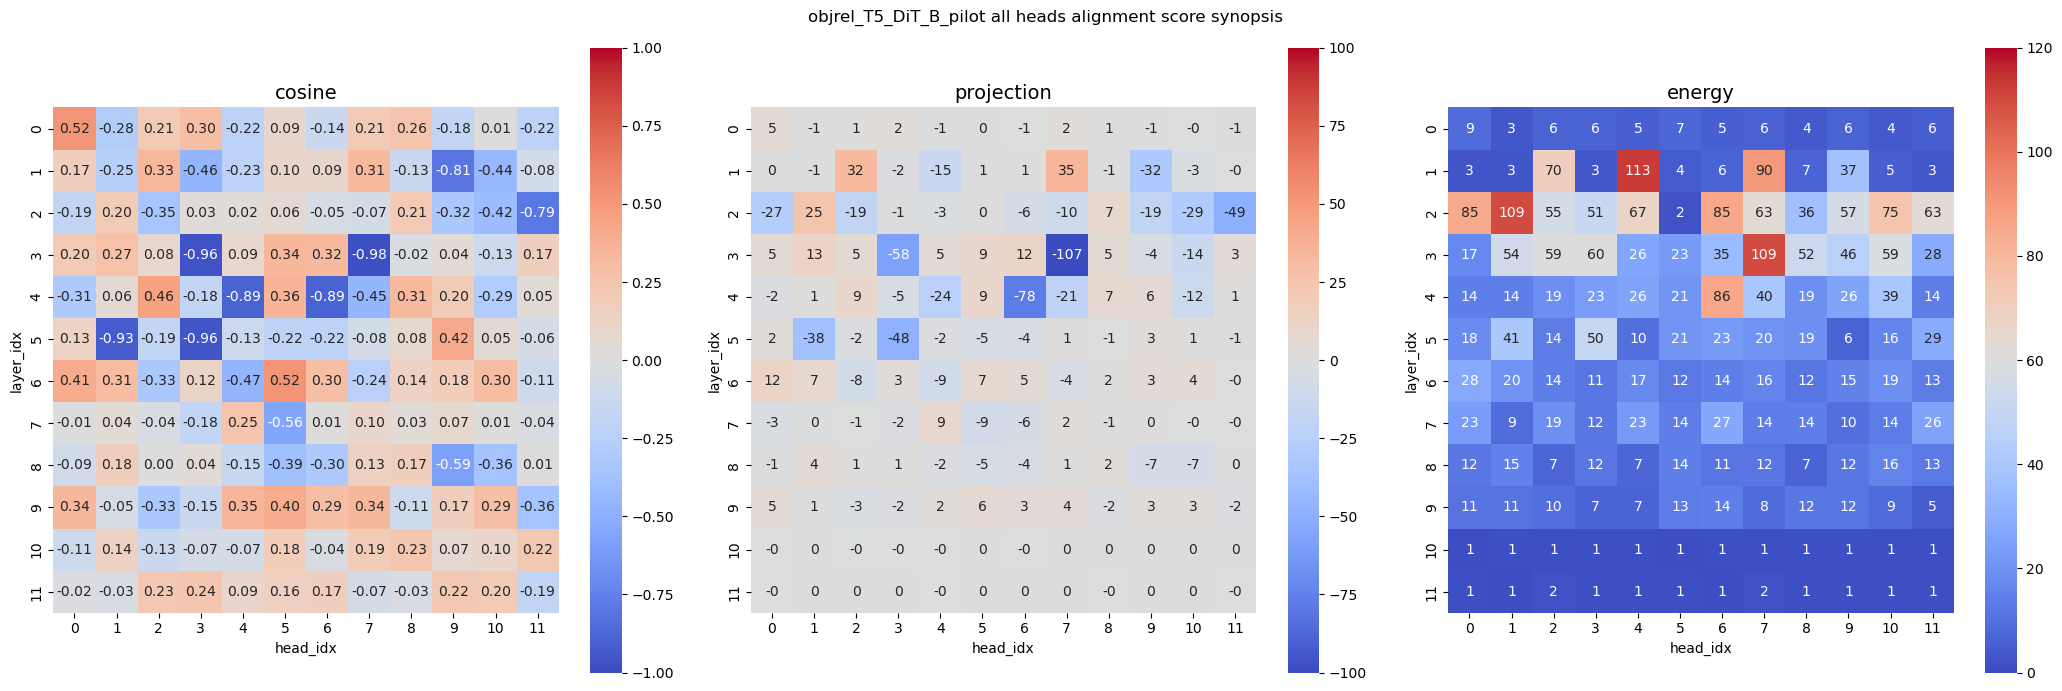

In [52]:
align_df_allheads.to_csv(join(figdir, f"{model_run_name}_align_score_allheads_shape2_MLP_proj_rel_factor.csv"), index=False)
head_align_synopsis = align_df_allheads.groupby(["layer_idx", "head_idx"]).mean(numeric_only=True)
# Plot each column in head_align_synopsis as a heatmap (layers x heads)
metrics = ["cosine", "projection", "energy", ]
n_metrics = len(metrics)
fig, axes = plt.subplots(1, n_metrics, figsize=(7*n_metrics, 7), squeeze=False)
for idx, metric, clim, fmt in zip(range(n_metrics), metrics, 
                                  [(-1, 1), (-100, 100), (0, 120)], 
                                  [".2f", ".0f", ".0f"]):
    # reshape values into 2D (layer, head)
    heatmap_data = head_align_synopsis[metric].unstack(level="head_idx")
    ax = axes[0, idx]
    sns.heatmap(heatmap_data, annot=True, fmt=fmt, cmap="coolwarm", ax=ax, cbar=True, vmin=clim[0], vmax=clim[1])
    ax.set_aspect("equal")
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("head_idx")
    ax.set_ylabel("layer_idx")
plt.suptitle(f"{model_run_name} all heads alignment score synopsis")
plt.tight_layout()
saveallforms(figdir, f"{model_run_name}_all_heads_align_score_synopsis_shape2_MLP_proj_rel_factor")
plt.show()

### Shape1

In [53]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]
print("shape2, T5 embedding, caption projection")
var_part_df_S1, intercept_S1, effect_vecs_S1, levels_map_S1, R2_total_S1 = variance_partition_with_effects(wordvec_obj1_mat_proj.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],
            #  "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
             "shape2": prompt_scene_info_all_df["shape2"],
             "color1shape1": prompt_scene_info_all_df["color1shape1"],
            #  "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df_S1

shape2, T5 embedding, caption projection
Total R2 (all features): 0.624690
Total R² (all features): 0.6247


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,color1shape1,6,5,249,4856.000138,1754.972863,0.361403,1646.176007,0.338998,0.474583,0.009901
1,spatial_relationship,8,7,249,4856.000138,914.715690,0.188368,914.715690,0.188368,0.334177,0.009901
2,shape2,3,2,249,4856.000138,472.604862,0.097324,363.808005,0.074919,0.166403,0.009901


In [54]:
from tqdm import tqdm
from itertools import product
transformer_config = PixArt_model_configs[config.model]
hidden_size = transformer_config["hidden_size"]
head_num = transformer_config["num_heads"]
layer_num = transformer_config["depth"]
base_size = 16 // 2
head_dim = hidden_size // head_num
device = "cuda"
align_df_list = []
for layer_idx, head_idx in tqdm(product(range(layer_num), range(head_num))):
    target_embedding_direction = effect_vecs_S1["spatial_relationship"][:, :]
    target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
    word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T
    align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map_S1["spatial_relationship"])
    align_df["layer_idx"] = layer_idx
    align_df["head_idx"] = head_idx
    align_df_list.append(align_df)
align_df_allheads_S1 = pd.concat(align_df_list)

0it [00:00, ?it/s]

144it [00:00, 416.24it/s]


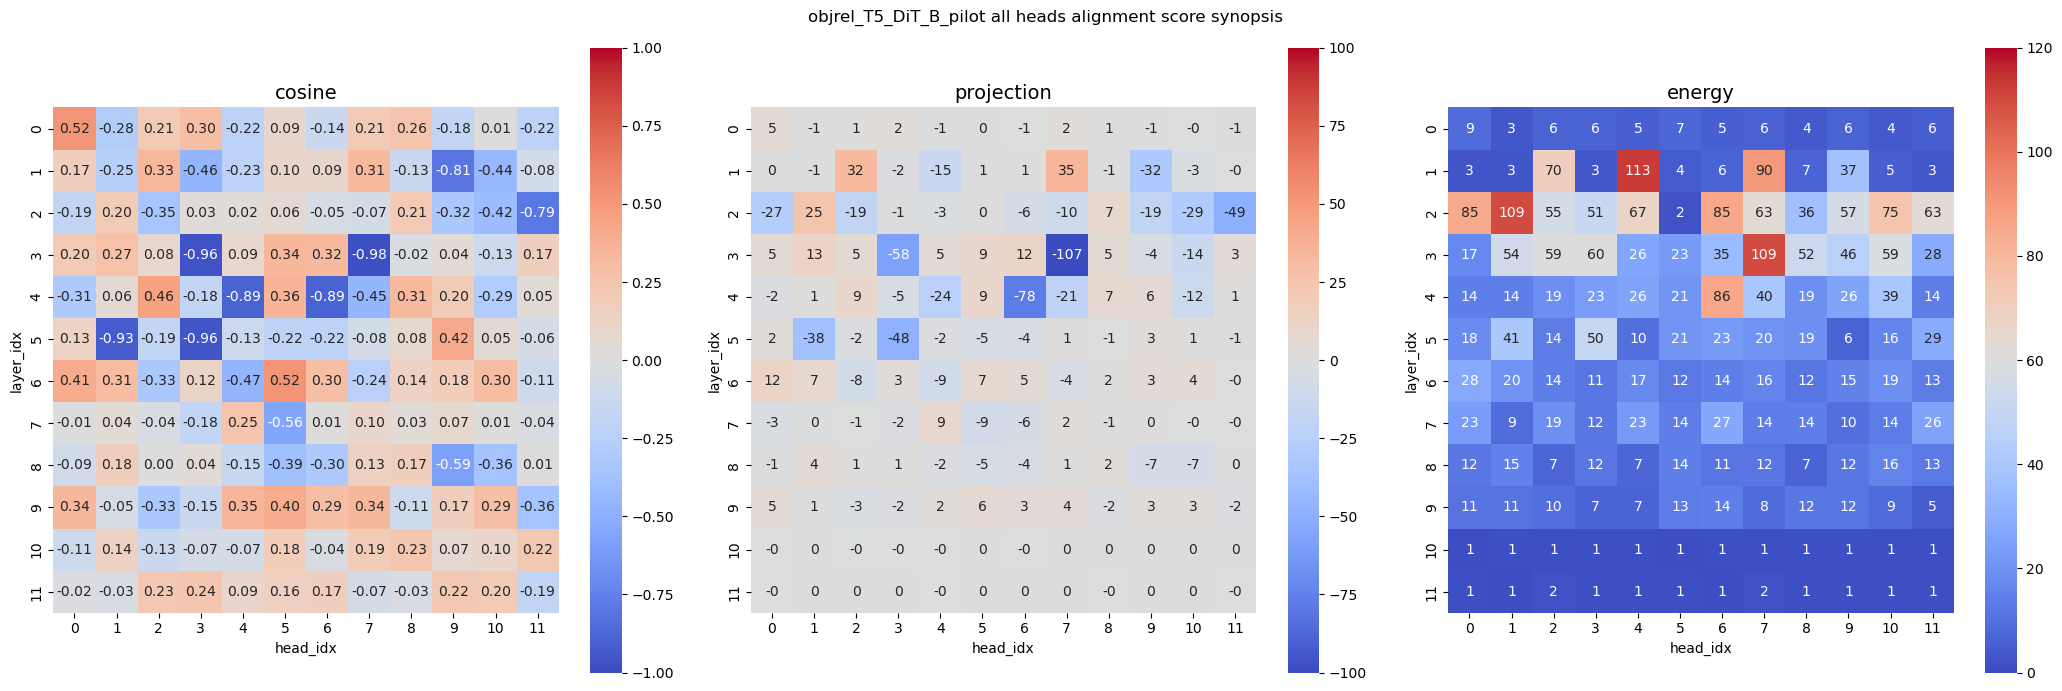

In [ ]:
align_df_allheads.to_csv(join(figdir, f"{model_run_name}_align_score_allheads_shape1_MLP_proj_rel_factor.csv"), index=False)
head_align_synopsis = align_df_allheads.groupby(["layer_idx", "head_idx"]).mean(numeric_only=True)
# Plot each column in head_align_synopsis as a heatmap (layers x heads)
metrics = ["cosine", "projection", "energy", ]
n_metrics = len(metrics)
fig, axes = plt.subplots(1, n_metrics, figsize=(7*n_metrics, 7), squeeze=False)
for idx, metric, clim, fmt in zip(range(n_metrics), metrics, 
                                  [(-1, 1), (-100, 100), (0, 120)], 
                                  [".2f", ".0f", ".0f"]):
    # reshape values into 2D (layer, head)
    heatmap_data = head_align_synopsis[metric].unstack(level="head_idx")
    ax = axes[0, idx]
    sns.heatmap(heatmap_data, annot=True, fmt=fmt, cmap="coolwarm", ax=ax, cbar=True, vmin=clim[0], vmax=clim[1])
    ax.set_aspect("equal")
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("head_idx")
    ax.set_ylabel("layer_idx")
plt.suptitle(f"{model_run_name} all heads alignment score synopsis")
plt.tight_layout()
saveallforms(figdir, f"{model_run_name}_all_heads_align_score_synopsis_shape1_MLP_proj_rel_factor")
plt.show()

### Selective visualize

Text(0.5, 0.98, 'objrel_T5_DiT_B_pilot\nL3H7 pos embed inner product with spatial relation factors in Caption Projection')

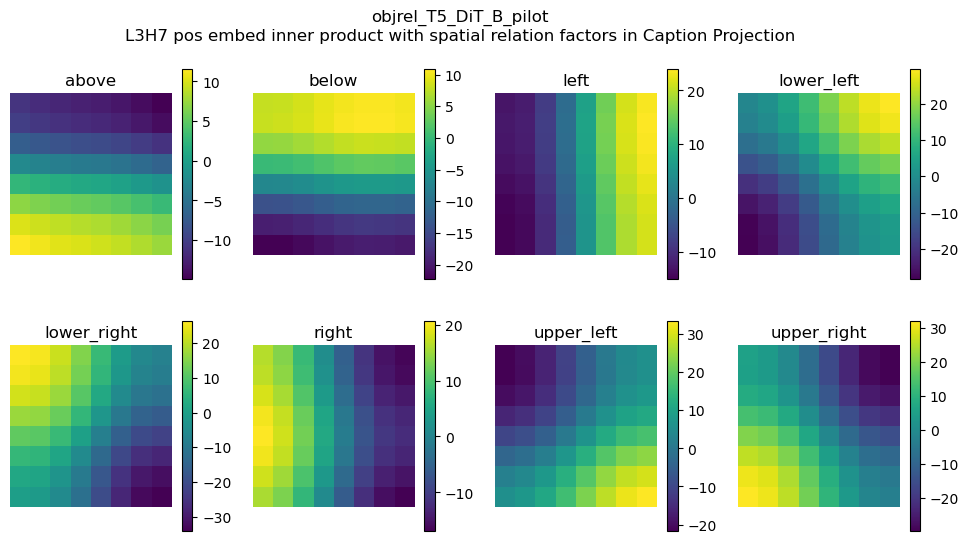

In [43]:
transformer_config = PixArt_model_configs[config.model]
hidden_size = transformer_config["hidden_size"]
head_num = transformer_config["num_heads"]
layer_num = transformer_config["depth"]
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx, head_idx = 3, 7
device = "cuda"
target_embedding_direction = effect_vecs["spatial_relationship"][:, :]
target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i_word in range(len(effect_vecs["spatial_relationship"])):
    plt.sca(axs[i_word])
    attn_score = inner_prod_mat[:, i_word:i_word+1]
    plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
    plt.title(f"{levels_map['spatial_relationship'][i_word]}")
    plt.axis("off")
    plt.colorbar()
plt.suptitle(f"{model_run_name}\nL{layer_idx}H{head_idx} pos embed inner product with spatial relation factors in Caption Projection")
# saveallforms(figdir, f"{run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_rel_factors_proj")

In [90]:
from utils.pixart_utils import PixArt_model_configs
def compute_vis_pos_embed_inner_prod(pipeline, config, layer_idx, head_idx, feature_vecs, levels_names=None, 
                                   model_run_name="model", device="cuda", visualize=True):
    """
    Visualize the inner product between 2D positional embeddings and target effect vectors for specified head/layer.

    Args:
        layer_idx: int, transformer block index (layer)
        head_idx: int, attention head index
        pipeline: model pipeline with .transformer.transformer_blocks
        effect_vecs: dict of [feature_name] -> np.ndarray (n_level, embed_dim)
        feature: str, which effect_vecs key to use (default: "spatial_relationship")
        model_run_name: str, for titling plots
        levels_map: dict of [feature] -> list of level names (labels for plot)
        device: str, torch device

    Returns: None (creates plot)
    """
    # Get model size info
    transformer_config = PixArt_model_configs[config.model] if config is not None else PixArt_model_configs["PixArt_B_2"]
    hidden_size = transformer_config["hidden_size"]
    head_num = transformer_config["num_heads"]
    layer_num = transformer_config["depth"]
    base_size = 16 // 2
    head_dim = hidden_size // head_num

    # Target embedding direction
    target_embedding_direction = feature_vecs[:, :]
    target_embedding_direction = torch.from_numpy(target_embedding_direction)[None, :].half().to(device)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(target_embedding_direction)
    word_embed_2k_h = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

    # Positional encoding
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().to(device))
    pos_embed_2q_h = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

    inner_prod_mat = pos_embed_2q_h @ word_embed_2k_h.T
    if visualize:
        num_levels = len(feature_vecs)
        nrows, ncols = (2, 4) if num_levels == 8 else (1, num_levels)
        fig, axs = plt.subplots(nrows, ncols, figsize=(12, 6))
        axs = axs.flatten() if hasattr(axs, "flatten") else [axs]

        for i_word in range(num_levels):
            plt.sca(axs[i_word])
            attn_score = inner_prod_mat[:, i_word:i_word+1]
            plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
            if levels_names is not None:
                plt.title(f"{levels_names[i_word]}")
            else:
                plt.title(f"{i_word}")
            plt.axis("off")
            plt.colorbar()
        plt.suptitle(f"{model_run_name}\nL{layer_idx}H{head_idx} pos embed inner product with {len(feature_vecs)} factors in Caption Projection")
        # Optionally, save: saveallforms(figdir, f"{model_run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_{feature}_proj")
        plt.tight_layout()
        plt.show()
    else:
        fig = None
    return inner_prod_mat, fig
# Example call (replace indices and other vars as needed):
# 

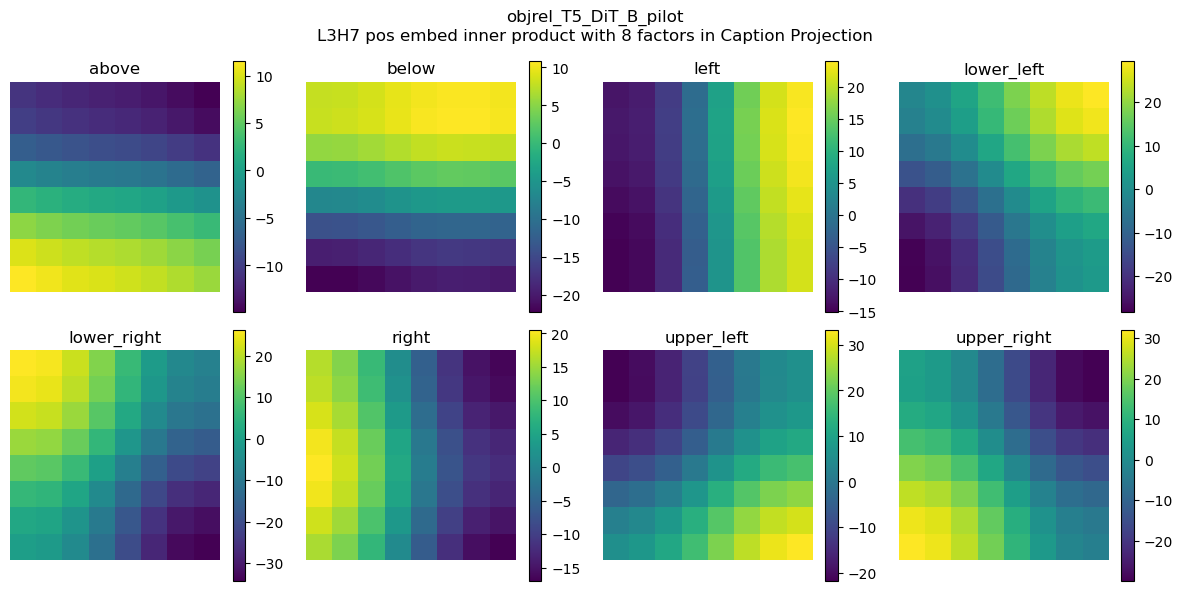

In [ ]:
inner_prod_mat, fig = compute_vis_pos_embed_inner_prod(pipeline, config, 3, 7, 
                                 effect_vecs["spatial_relationship"], 
                                 levels_names=levels_map["spatial_relationship"], 
                                 model_run_name=model_run_name, 
                                 device="cuda", visualize=True);

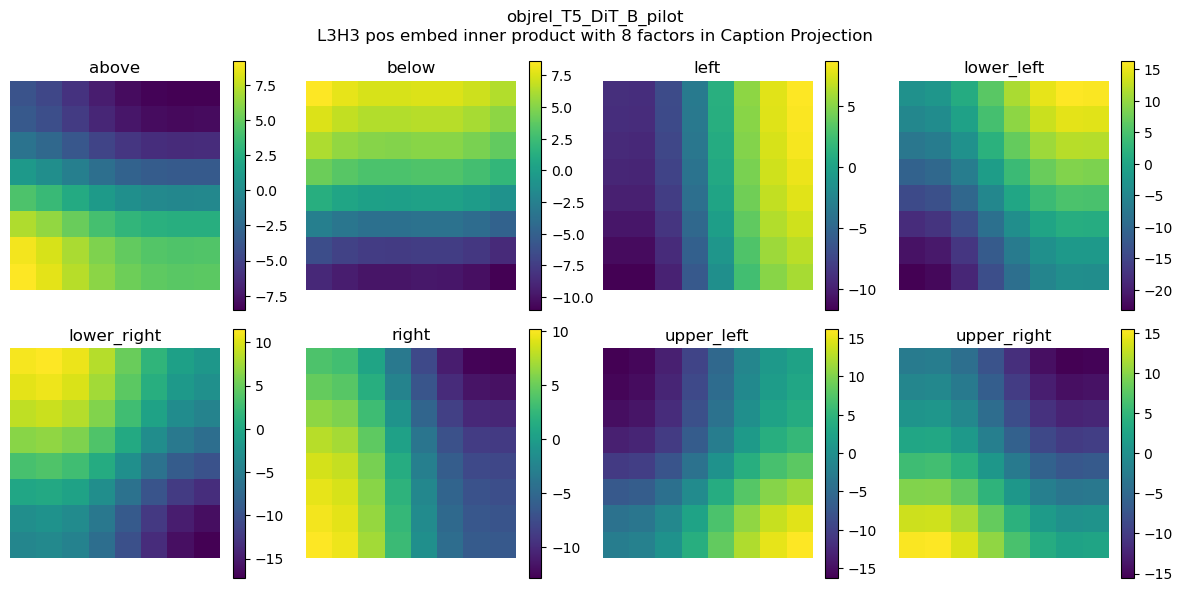

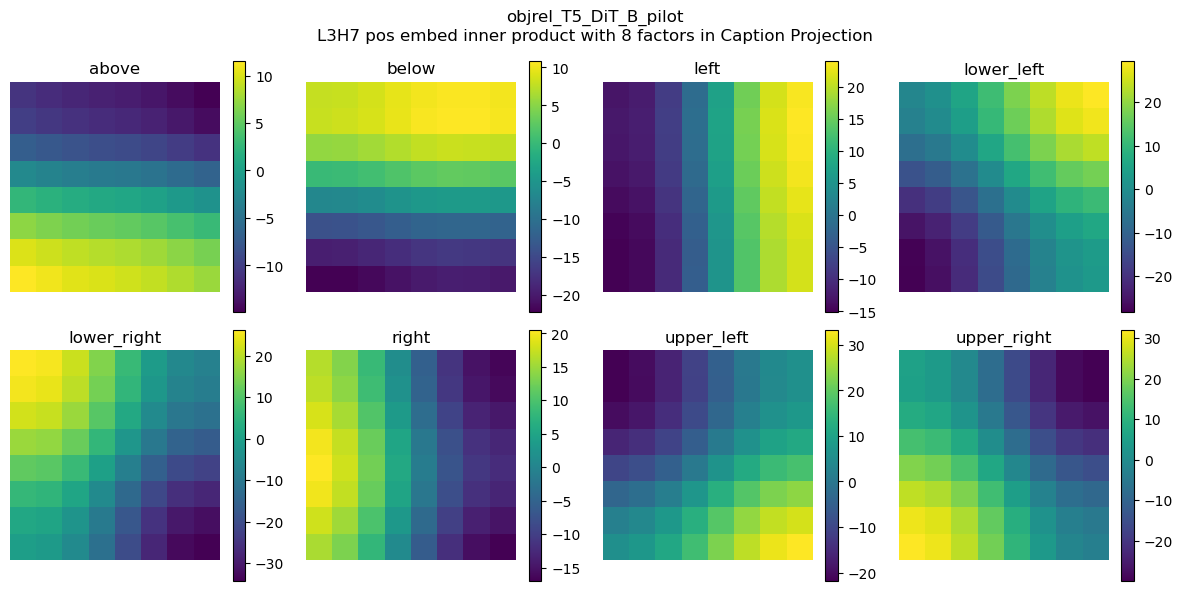

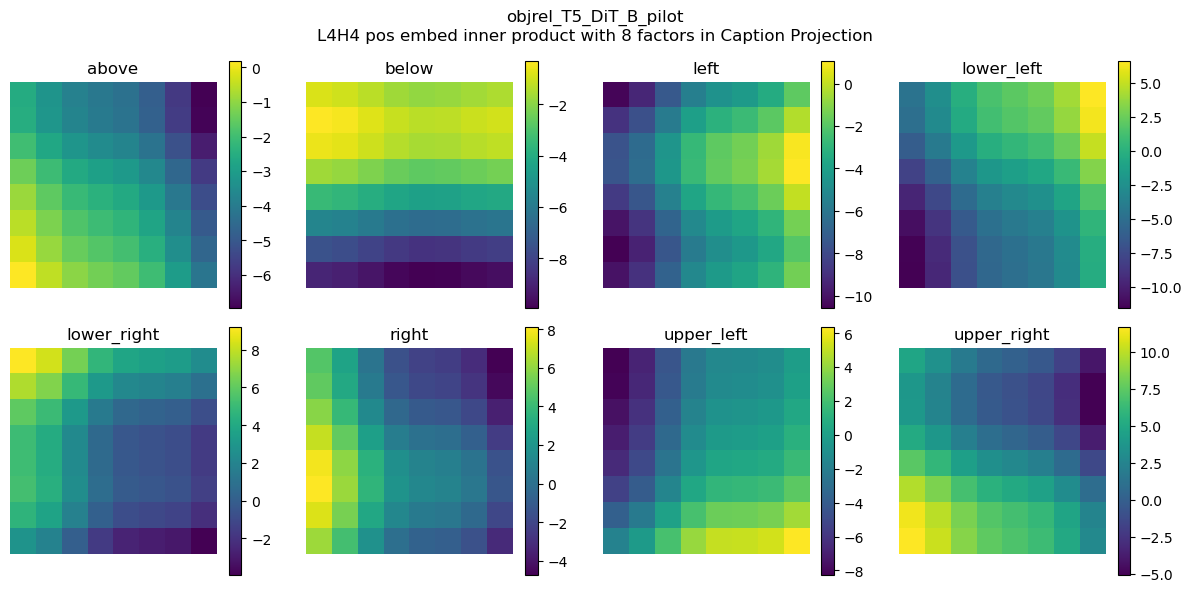

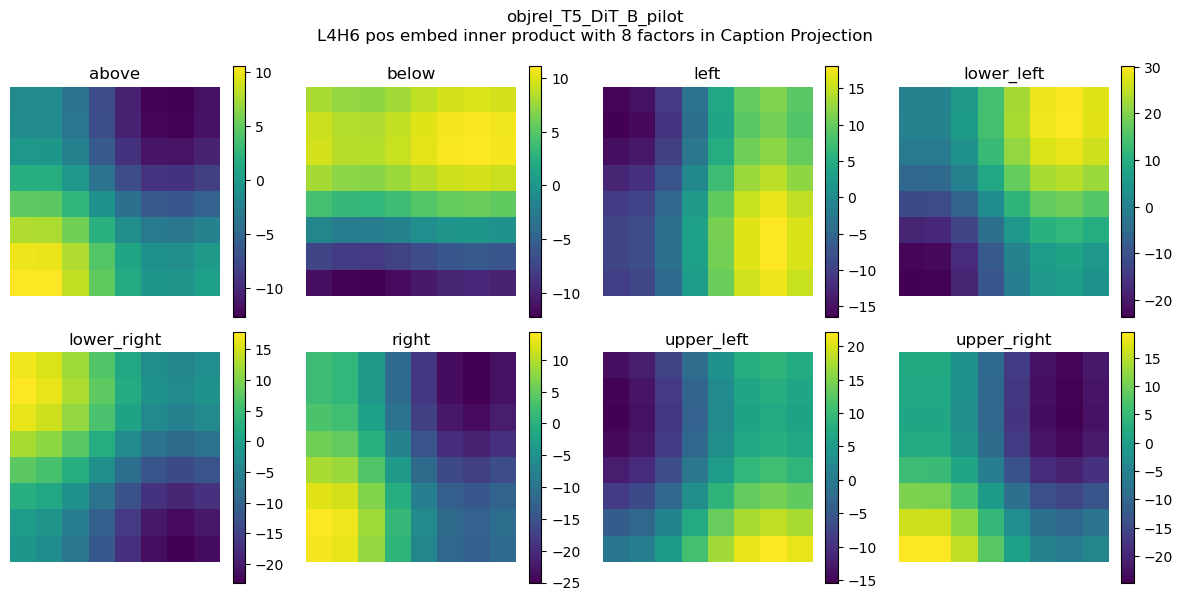

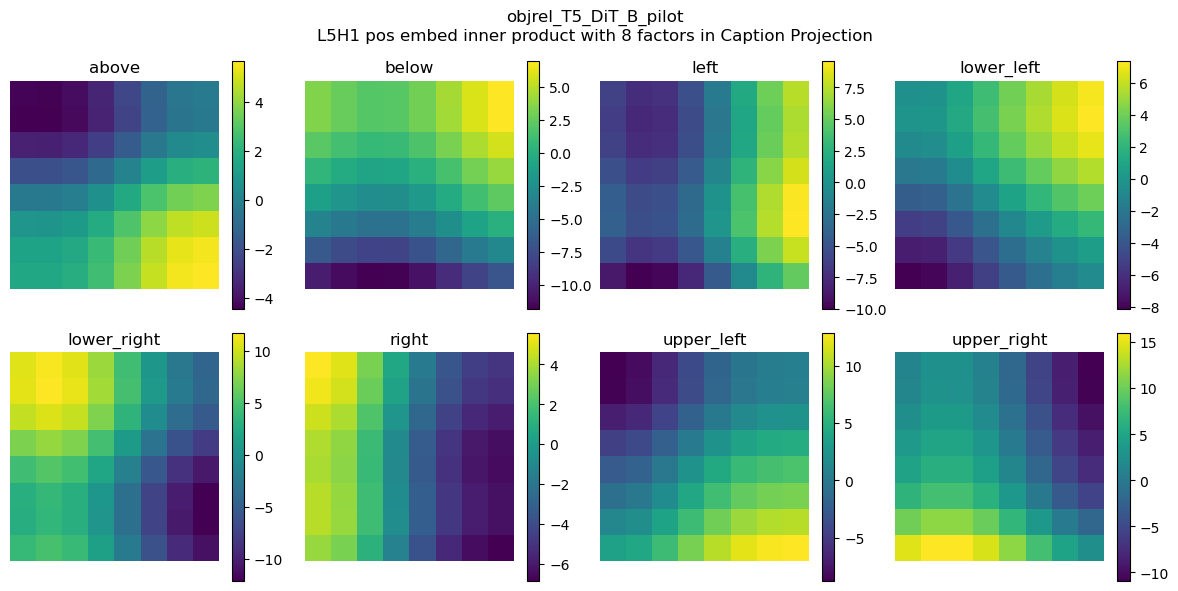

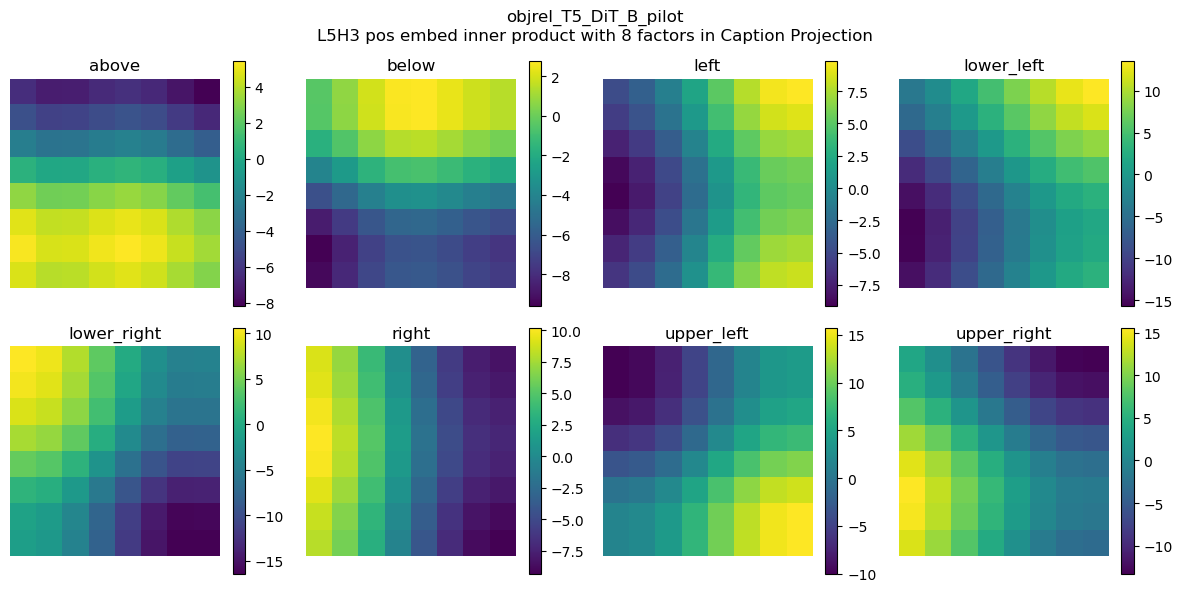

In [ ]:
for layer_idx, head_idx in [(3,3),(3,7), (4,4), (4,6), (5,1), (5,3)]:
    inner_prod_mat, fig = compute_vis_pos_embed_inner_prod(pipeline, config, layer_idx, head_idx, 
                                     effect_vecs["spatial_relationship"], 
                                     levels_names=levels_map["spatial_relationship"], 
                                     model_run_name=model_run_name, 
                                     device="cuda", visualize=True);

### Test model 

  0%|          | 0/14 [00:00<?, ?it/s]

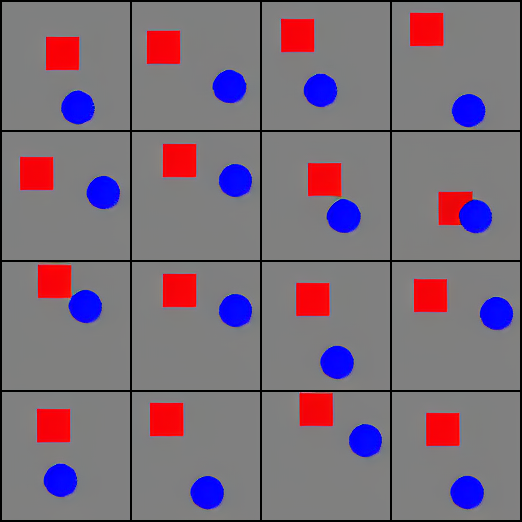

In [38]:
output = pipeline("red square is above and to the left of blue circle",
        num_inference_steps=14,
        max_sequence_length=20, 
        generator=torch.Generator(device="cuda").manual_seed(42),
        guidance_scale=4.5,
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        prompt_dtype=torch.float16,
        device="cuda")
noise_pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

  0%|          | 0/14 [00:00<?, ?it/s]

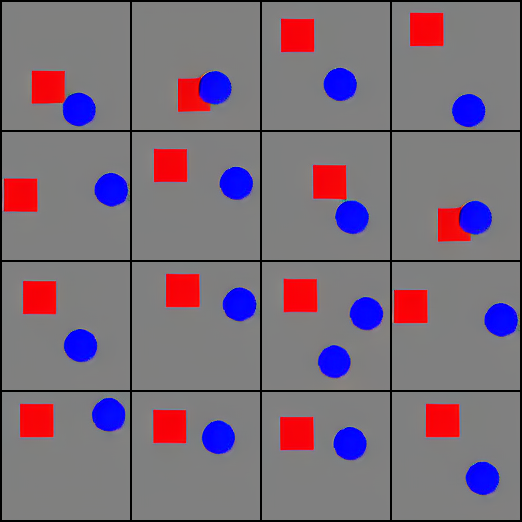

In [40]:
output = pipeline("the red square is above and to the left of  blue circle",
        num_inference_steps=14,
        max_sequence_length=20, 
        generator=torch.Generator(device="cuda").manual_seed(42),
        guidance_scale=4.5,
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        prompt_dtype=torch.float16,
        device="cuda")
noise_pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

### Bias effect of adding the 

In [56]:
from easydict import EasyDict as edict
def compute_shape_wordvecs_and_project(
    pipeline, 
    prompt_template="{color1} {shape1} is {rel_text} {color2} {shape2}",
    max_sequence_length=20, 
    device="cuda"
):
    dataset_tmp = ShapesDataset(num_images=10000)
    prompt_collection_all, scene_info_collection_all = generate_all_prompt_collection(
        dataset_tmp.spatial_phrases,
        prompt_template=prompt_template,
    )
    embedding_allrel_allobj = precompute_embeddings(
        {"base": (prompt_collection_all, scene_info_collection_all)}, 
        pipeline.tokenizer, pipeline.text_encoder, 
        max_sequence_length=max_sequence_length, device=device
    )
    prompt_scene_info_all_df = pd.DataFrame(scene_info_collection_all)
    prompt_scene_info_all_df["prompt"] = prompt_collection_all

    wordvec_obj1_col = []
    wordvec_obj2_col = []
    for row in prompt_scene_info_all_df.itertuples():
        tokenized = pipeline.tokenizer(
            row.prompt, max_length=max_sequence_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        token_ids = tokenized['input_ids'][0]
        tokens = [pipeline.tokenizer.decode([token_id]) for token_id in token_ids]

        shape1_mask_idx = find_shape_index(tokens, row.shape1)
        shape2_mask_idx = find_shape_index(tokens, row.shape2)
        cap_embeds = embedding_allrel_allobj[f"base::{row.prompt}"]['caption_embeds']
        if shape1_mask_idx is None or shape2_mask_idx is None:
            print(f"Prompt: {row.prompt}")
            print(f"Shape1 ({row.shape1}) at index: {shape1_mask_idx}")
            print(f"Shape2 ({row.shape2}) at index: {shape2_mask_idx}")
            print("---")
            raise ValueError("Shape index not found")
        wordvec_obj1_col.append(cap_embeds[0, shape1_mask_idx, :])
        wordvec_obj2_col.append(cap_embeds[0, shape2_mask_idx, :])
    wordvec_obj1_mat = torch.stack(wordvec_obj1_col, dim=0)
    wordvec_obj2_mat = torch.stack(wordvec_obj2_col, dim=0)
    with torch.no_grad():
        wordvec_obj1_mat_proj = pipeline.transformer.caption_projection(wordvec_obj1_mat.half().cuda())
        wordvec_obj2_mat_proj = pipeline.transformer.caption_projection(wordvec_obj2_mat.half().cuda())
    return edict({
        "prompt_scene_info_all_df": prompt_scene_info_all_df,
        "wordvec_obj1_mat": wordvec_obj1_mat,
        "wordvec_obj2_mat": wordvec_obj2_mat,
        "wordvec_obj1_mat_proj": wordvec_obj1_mat_proj,
        "wordvec_obj2_mat_proj": wordvec_obj2_mat_proj,
    })

# Example call (optional, you may uncomment in your notebook):
# result = compute_shape_wordvecs_and_project(pipeline)
# prompt_scene_info_all_df = result["prompt_scene_info_all_df"]
# wordvec_obj1_mat = result["wordvec_obj1_mat"]
# wordvec_obj2_mat = result["wordvec_obj2_mat"]
# wordvec_obj1_mat_proj = result["wordvec_obj1_mat_proj"]
# wordvec_obj2_mat_proj = result["wordvec_obj2_mat_proj"]

In [80]:
figdir_the = "/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_T5_the_repr_bias"

In [79]:
original_wordvecs = compute_shape_wordvecs_and_project(pipeline, prompt_template="{color1} {shape1} is {rel_text} {color2} {shape2}", )
the1_wordvecs = compute_shape_wordvecs_and_project(pipeline, prompt_template="the {color1} {shape1} is {rel_text} {color2} {shape2}", )
the2_wordvecs = compute_shape_wordvecs_and_project(pipeline, prompt_template="{color1} {shape1} is {rel_text} the {color2} {shape2}", )
the12_wordvecs = compute_shape_wordvecs_and_project(pipeline, prompt_template="the {color1} {shape1} is {rel_text} the {color2} {shape2}", )

Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)
Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)
Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)
Pre-computing text embeddings for all prompts...
Computing unconditional embedding...


Computing embeddings:   0%|          | 0/265 [00:00<?, ?it/s]

Cached embeddings for 265 unique prompts (including uncond)


In [81]:
pkl.dump(original_wordvecs, open(join(figdir_the, "T5_shape12_wordvecs_original.pkl"), "wb"))
pkl.dump(the1_wordvecs, open(join(figdir_the, "T5_shape12_wordvecs_the1.pkl"), "wb"))
pkl.dump(the2_wordvecs, open(join(figdir_the, "T5_shape12_wordvecs_the2.pkl"), "wb"))
pkl.dump(the12_wordvecs, open(join(figdir_the, "T5_shape12_wordvecs_the12.pkl"), "wb"))

In [58]:
prompt_scene_info_all_df["color1shape1"] = prompt_scene_info_all_df["color1"] + "_" + prompt_scene_info_all_df["shape1"]
prompt_scene_info_all_df["color2shape2"] = prompt_scene_info_all_df["color2"] + "_" + prompt_scene_info_all_df["shape2"]
print("shape2, T5 embedding, caption projection")
var_part_df, intercept, effect_vecs, levels_map, R2_total = variance_partition_with_effects(original_wordvecs.wordvec_obj2_mat_proj.float().cpu().numpy(),
            {"spatial_relationship": prompt_scene_info_all_df["spatial_relationship"],
            #  "color1": prompt_scene_info_all_df["color1"],
            #  "shape1": prompt_scene_info_all_df["shape1"],
            #  "color2": prompt_scene_info_all_df["color2"],
             "shape2": prompt_scene_info_all_df["shape2"],
             "color1shape1": prompt_scene_info_all_df["color1shape1"],
            #  "color2shape2": prompt_scene_info_all_df["color2shape2"],
             },
            metric="euclidean",
            n_perm=100)
var_part_df

shape2, T5 embedding, caption projection
Total R2 (all features): 0.544059
Total R² (all features): 0.5441


,feature,levels,df_effect,df_resid,SS_total,SSR_marginal,R2_marginal,SSR_partial,R2_partial,eta2_partial,p_partial_perm
0,spatial_relationship,8,7,249,5780.676321,1230.125993,0.212800,1230.125993,0.212800,0.318209,0.009901
1,color1shape1,6,5,249,5780.676321,1051.688013,0.181932,938.457129,0.162344,0.262571,0.009901
2,shape2,3,2,249,5780.676321,976.443760,0.168915,863.212876,0.149327,0.246712,0.009901


In [82]:
the1_pert_vecs = the1_wordvecs.wordvec_obj2_mat_proj - original_wordvecs.wordvec_obj2_mat_proj 
the1_pert_vecs_mean = the1_pert_vecs.mean(dim=0)
the2_pert_vecs = the2_wordvecs.wordvec_obj2_mat_proj - original_wordvecs.wordvec_obj2_mat_proj 
the2_pert_vecs_mean = the2_pert_vecs.mean(dim=0)
the12_pert_vecs = the12_wordvecs.wordvec_obj2_mat_proj - original_wordvecs.wordvec_obj2_mat_proj 
the12_pert_vecs_mean = the12_pert_vecs.mean(dim=0)


In [84]:
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
# Get the spatial relationship effect vectors and the mean perturbation vector as numpy arrays
spatial_featvecs = effect_vecs["spatial_relationship"]
if isinstance(spatial_featvecs, torch.Tensor):
    spatial_featvecs = spatial_featvecs.float().cpu().numpy()
pert_vec1 = the1_pert_vecs_mean.float().cpu().numpy()[None, :]
pert_vec2 = the2_pert_vecs_mean.float().cpu().numpy()[None, :]
pert_vec12 = the12_pert_vecs_mean.float().cpu().numpy()[None, :]
# Compute cosine similarity between each effect vector and the perturbation vector
cos_sims1 = cosine_similarity(spatial_featvecs, pert_vec1)
inner_prod1 = spatial_featvecs @ pert_vec1.T
cos_sims2 = cosine_similarity(spatial_featvecs, pert_vec2)
inner_prod2 = spatial_featvecs @ pert_vec2.T
cos_sims12 = cosine_similarity(spatial_featvecs, pert_vec12)
inner_prod12 = spatial_featvecs @ pert_vec12.T
spatial_levels = levels_map["spatial_relationship"]
spatial_sim_df = pd.DataFrame({
    "spatial_relation": spatial_levels,
    "cosine[the1]": cos_sims1.flatten(),
    "dotprod[the1]": inner_prod1.flatten(),
    "cosine[the2]": cos_sims2.flatten(),
    "dotprod[the2]": inner_prod2.flatten(),
    "cosine[the12]": cos_sims12.flatten(),
    "dotprod[the12]": inner_prod12.flatten(),
})
display(spatial_sim_df)
spatial_sim_df.to_csv(join(figdir_the, "T5_shape12_the_repr_bias_spatial_sim_df.csv"), index=False)

,spatial_relation,cosine[the1],dotprod[the1],cosine[the2],dotprod[the2],cosine[the12],dotprod[the12]
0,above,-0.272008,-1.240230,-0.213601,-1.060072,-0.305561,-1.256916
1,below,-0.018963,-0.088364,-0.277139,-1.405675,-0.232015,-0.975393
2,left,0.039313,0.173991,0.223640,1.077349,0.114195,0.455964
3,lower_left,0.744208,3.087336,0.518779,2.342524,0.573505,2.146415
4,lower_right,0.081643,0.314101,-0.199650,-0.836051,-0.007089,-0.024605
5,right,-0.557453,-2.522166,-0.438664,-2.160281,-0.413982,-1.689797
6,upper_left,0.376111,1.459926,0.608468,2.570775,0.496800,1.739736
7,upper_right,-0.308902,-1.184594,-0.126631,-0.528570,-0.114289,-0.395404


### Effect on cross attention maps

In [92]:
figdir_the

'/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_T5_the_repr_bias'

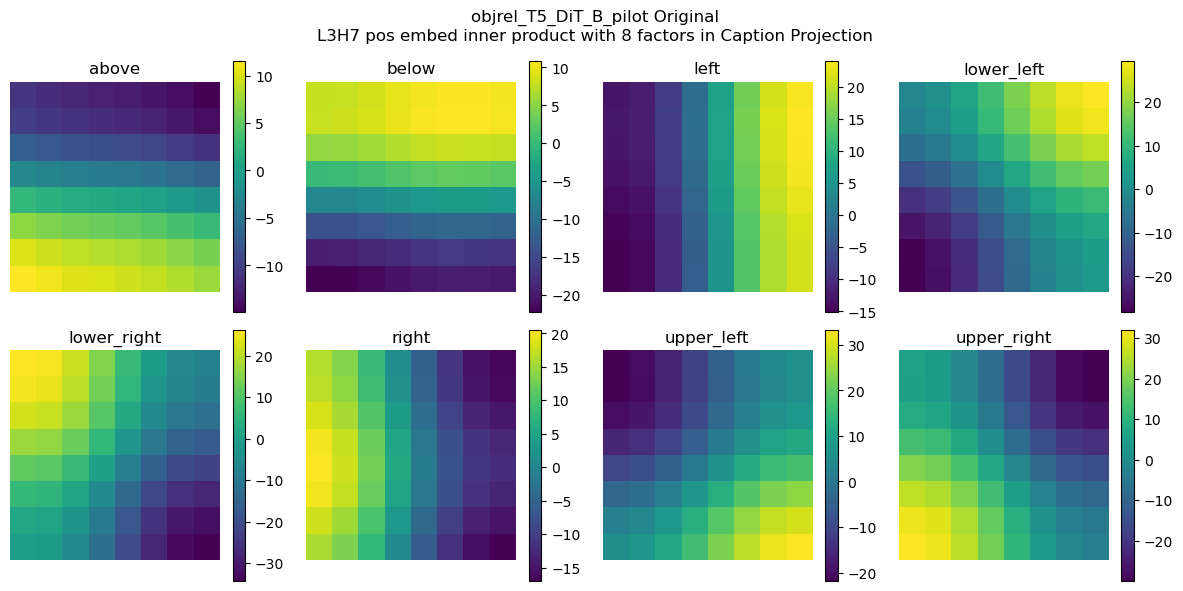

,cosine,projection,energy,template_norm,rel_name,dvec,dir_idx
0,-0.978780,-66.679391,68.1250,5.237229,above,"(0, -1)",0
1,-0.975373,-90.648756,92.9375,5.237229,below,"(0, 1)",1
2,-0.981952,-109.794499,111.8125,5.237229,left,"(-1, 0)",2
3,-0.985828,-121.256892,123.0000,5.237229,lower_left,"(-1, 1)",3
4,-0.977049,-127.504859,130.5000,5.237229,lower_right,"(1, 1)",4
5,-0.980212,-96.060730,98.0000,5.237229,right,"(1, 0)",5
6,-0.981850,-113.894633,116.0000,5.237229,upper_left,"(-1, -1)",6
7,-0.977425,-131.952382,135.0000,5.237229,upper_right,"(1, -1)",7


cosine            -0.979809
projection      -107.224017
energy           109.421875
template_norm      5.237229
dir_idx            3.500000
dtype: float64

In [101]:
layer_idx, head_idx = 3, 7
inner_prod_mat, fig = compute_vis_pos_embed_inner_prod(pipeline, config, layer_idx, head_idx, 
                                 effect_vecs["spatial_relationship"],# + the2_pert_vecs_mean.detach().cpu().numpy()[None, :], 
                                 levels_names=levels_map["spatial_relationship"], 
                                 model_run_name=model_run_name + " Original", 
                                 device="cuda", visualize=True);
align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["spatial_relationship"])
display(align_df)
display(align_df.mean(numeric_only=True))
saveallforms(figdir_the, f"{model_run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_spatial_rel_proj_original", figh=fig)
align_df.to_csv(join(figdir_the, f"{model_run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_spatial_rel_proj_original_align_df.csv"), index=False)

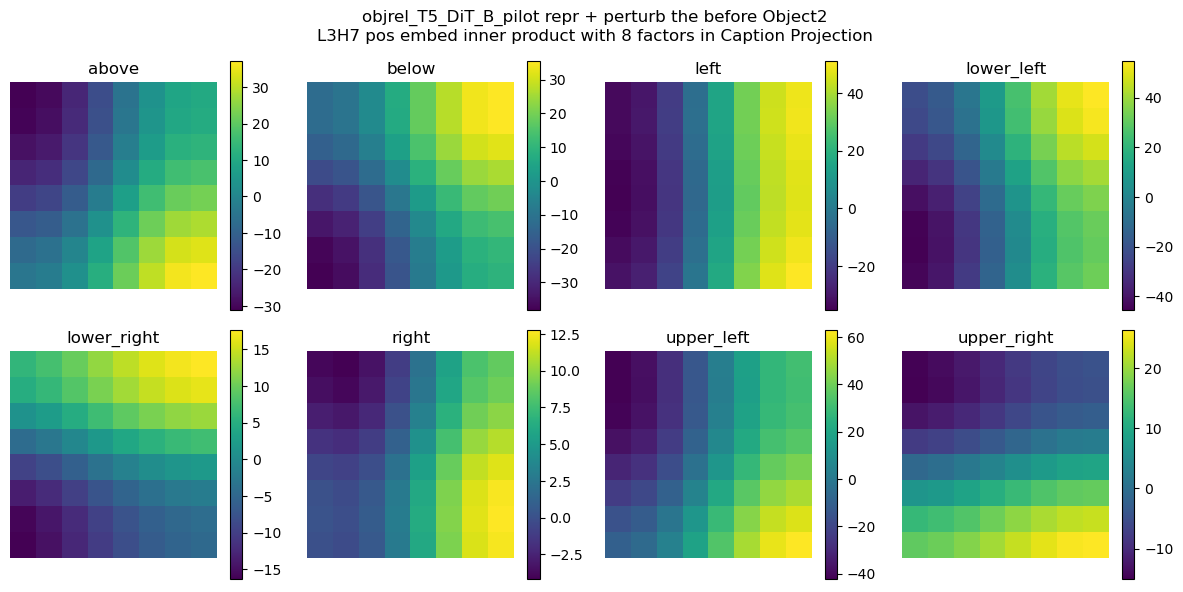

,cosine,projection,energy,template_norm,rel_name,dvec,dir_idx
0,-0.516928,-77.151558,149.25000,5.237229,above,"(0, -1)",0
1,-0.482527,-80.159753,166.12500,5.237229,below,"(0, 1)",1
2,-0.986298,-244.848358,248.25000,5.237229,left,"(-1, 0)",2
3,-0.873718,-209.364557,239.62500,5.237229,lower_left,"(-1, 1)",3
4,-0.323736,-24.583714,75.93750,5.237229,lower_right,"(1, 1)",4
5,0.927077,38.966225,42.03125,5.237229,right,"(1, 0)",5
6,-0.910989,-216.815495,238.00000,5.237229,upper_left,"(-1, -1)",6
7,-0.445972,-43.900320,98.43750,5.237229,upper_right,"(1, -1)",7


cosine            -0.451636
projection      -107.232191
energy           157.207031
template_norm      5.237229
dir_idx            3.500000
dtype: float64

In [102]:
inner_prod_mat, fig = compute_vis_pos_embed_inner_prod(pipeline, config, 3, 7, 
                                 effect_vecs["spatial_relationship"] + the2_pert_vecs_mean.detach().cpu().numpy()[None, :], 
                                 levels_names=levels_map["spatial_relationship"], 
                                 model_run_name=model_run_name + " repr + perturb the before Object2", 
                                 device="cuda", visualize=True);
align_df = eval_ramp_alignment_all(inner_prod_mat, levels_map["spatial_relationship"])
display(align_df)
display(align_df.mean(numeric_only=True))
saveallforms(figdir_the, f"{model_run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_spatial_rel_proj_the2_vecperturb", figh=fig)
align_df.to_csv(join(figdir_the, f"{model_run_name}_L{layer_idx}H{head_idx}_pos_embed_inprod_with_spatial_rel_proj_the2_vecperturb_align_df.csv"), index=False)

### Low dim visulization of vectors

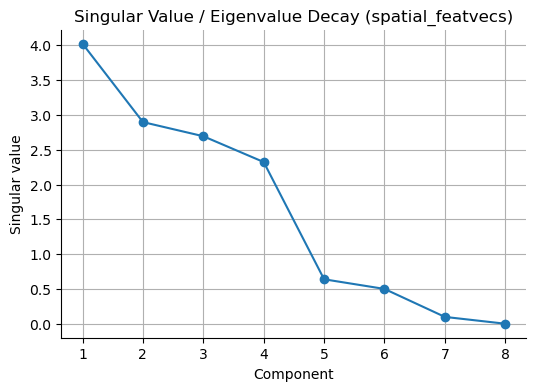

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute singular values (equivalent to eigenvalues of spatial_featvecs @ spatial_featvecs.T)
u, s, vh = np.linalg.svd(spatial_featvecs, full_matrices=False)
plt.figure(figsize=(5,4))
plt.plot(np.arange(1, len(s)+1), s, marker='o')
plt.title("Singular Value / Eigenvalue Decay (spatial_featvecs)")
plt.xlabel("Component")
plt.ylabel("Singular value")
# plt.yscale("log")
plt.grid(True, which='both')
plt.show()

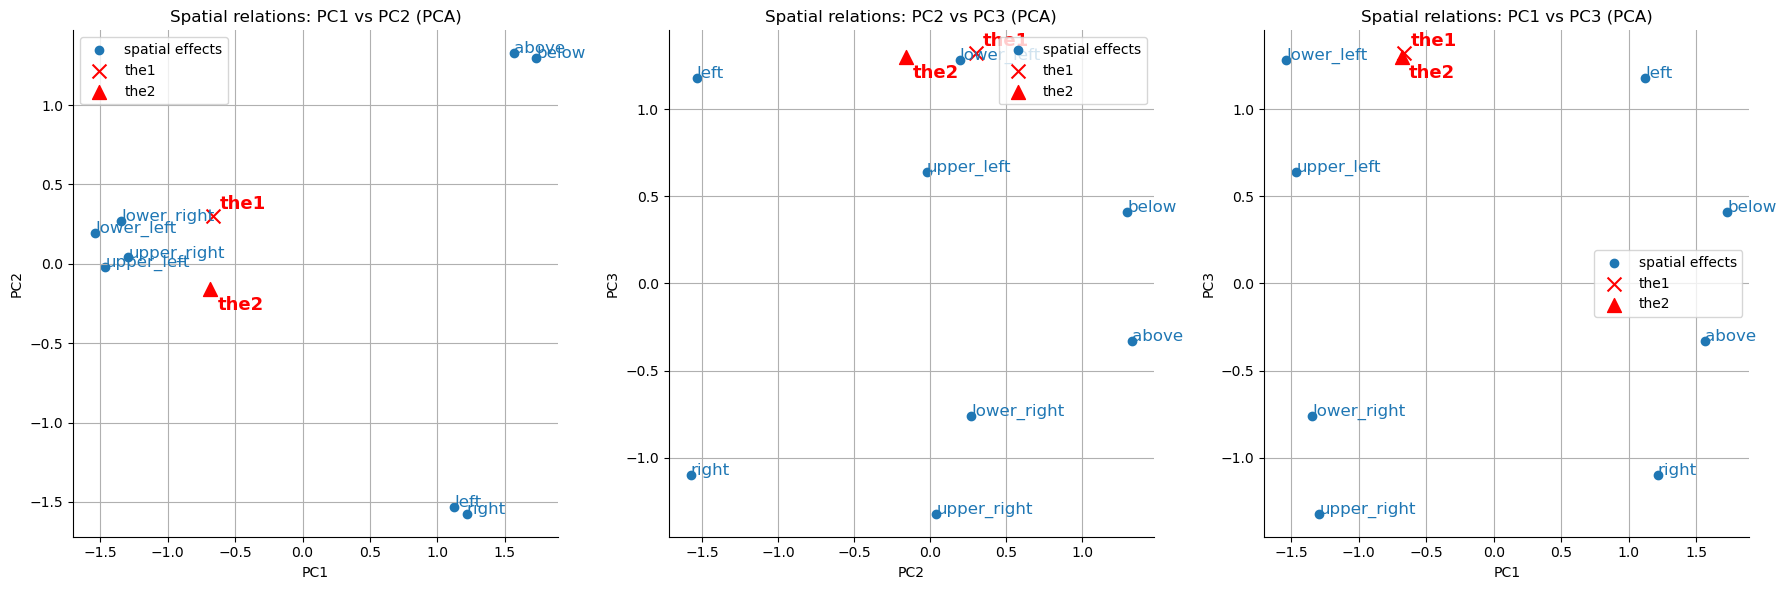

In [78]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA only on spatial_featvecs (exclude "the1" and "the2" pert_vecs)
pca = PCA(n_components=3)
pca.fit(spatial_featvecs)
spatial_pca = pca.transform(spatial_featvecs)
the1_pca = pca.transform(pert_vec1)[0]
the2_pca = pca.transform(pert_vec2)[0]

# Define projections to plot: (PC1 vs PC2), (PC2 vs PC3), (PC1 vs PC3)
projections = [("PC1", "PC2", 0, 1), ("PC2", "PC3", 1, 2), ("PC1", "PC3", 0, 2)]
spatial_levels = list(spatial_levels)

fig, axes = plt.subplots(1, len(projections), figsize=(6*len(projections),6), squeeze=False)
for ax, (xlab, ylab, xi, yi) in zip(axes[0], projections):
    # Plot spatial relationship effect vectors
    ax.scatter(spatial_pca[:, xi], spatial_pca[:, yi], color='C0', label="spatial effects")
    for i, label in enumerate(spatial_levels):
        ax.annotate(label, (spatial_pca[i, xi], spatial_pca[i, yi]), fontsize=12, color="C0")
    # Plot "the1" and "the2" in red
    ax.scatter([the1_pca[xi]], [the1_pca[yi]], color="red", marker="x", s=100, label="the1")
    ax.scatter([the2_pca[xi]], [the2_pca[yi]], color="red", marker="^", s=100, label="the2")
    ax.annotate("the1", (the1_pca[xi], the1_pca[yi]), color="red", fontsize=13, weight="bold", xytext=(5, 5), textcoords='offset points')
    ax.annotate("the2", (the2_pca[xi], the2_pca[yi]), color="red", fontsize=13, weight="bold", xytext=(5, -15), textcoords='offset points')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(f"Spatial relations: {xlab} vs {ylab} (PCA)")
    ax.grid(True)
    ax.legend(loc="best")
plt.tight_layout()
plt.show()
